Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [58]:
from sklearn.datasets import load_digits
x = load_digits().data
y = load_digits().target

In [2]:
x.shape

(1797, 64)

In [3]:
y.shape

(1797,)

Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

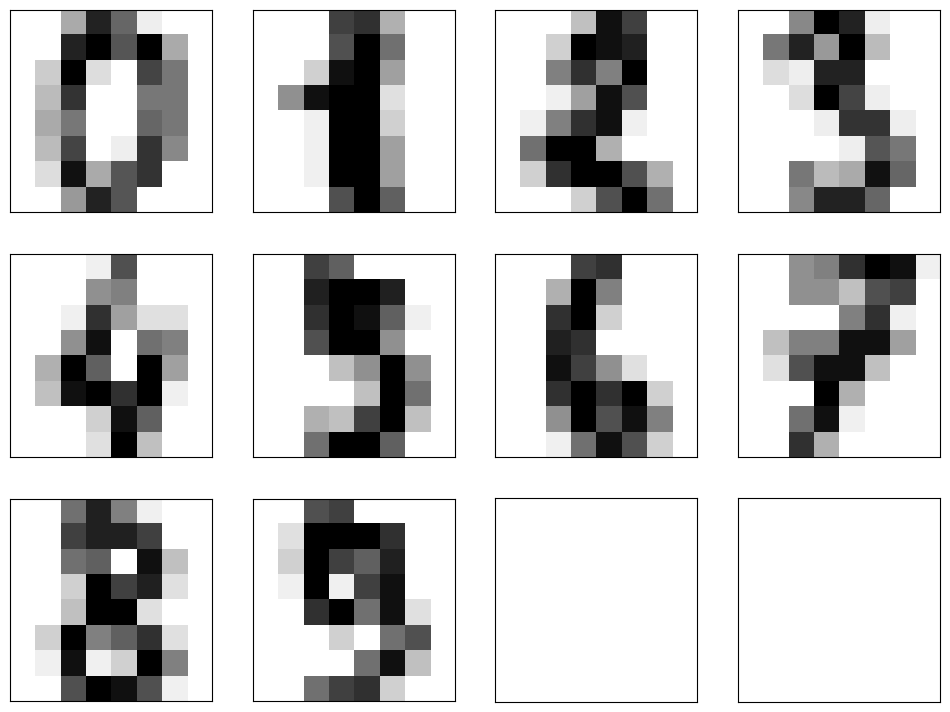

In [4]:
import numpy as np
import matplotlib.pyplot as plt
fig, axis = plt.subplots(nrows=3, ncols=4, figsize=(12,9))
for r_axis in axis:
    for ax in r_axis:
        ax.set_xticks([])
        ax.set_yticks([])
x = x.reshape(-1,8,8)
k = 0
for i in range(3):
    for j in range(4):
        if k == 10:
            break
        image = 1 - x[k]
        axis[i,j].imshow(image, cmap='gray')
        k+=1

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [5]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

x = x.reshape(-1,64)

kmeans = KMeans(n_clusters=10, n_init=100, random_state=23)
y_kmeans_predict = kmeans.fit_predict(x)

ac = AgglomerativeClustering(n_clusters=10)
y_ac_predict = ac.fit_predict(x)

print(f'Kmeans: {y_kmeans_predict.shape}\nAgglomerativeClustering:{y_ac_predict.shape}')

Kmeans: (1797,)
AgglomerativeClustering:(1797,)


Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

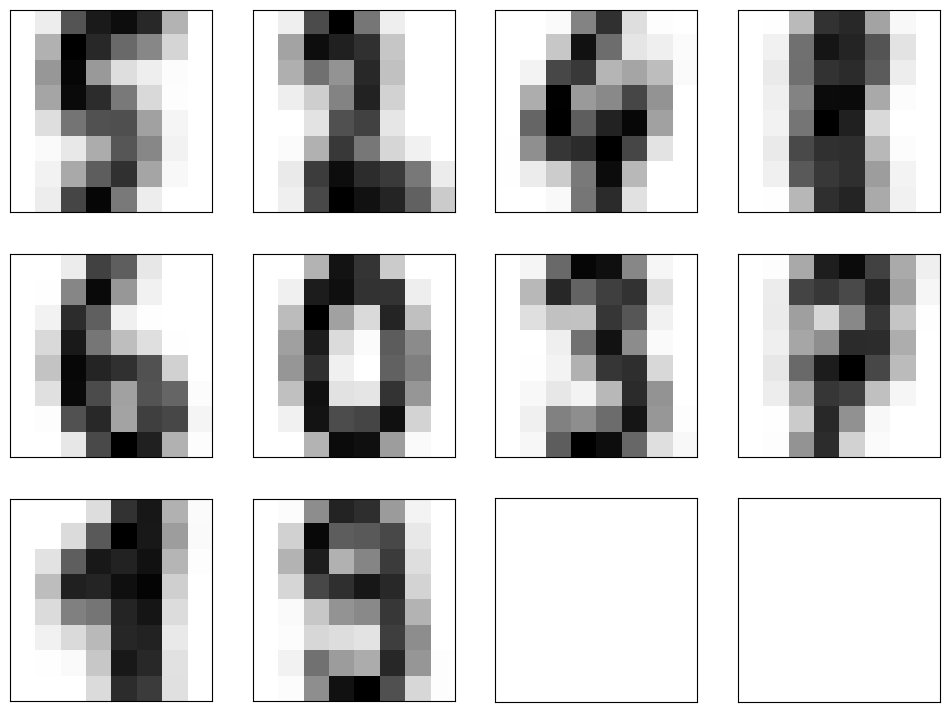

In [6]:
fig, axis = plt.subplots(nrows=3, ncols=4, figsize=(12,9))
kmeans_clusters = kmeans.cluster_centers_.reshape(-1,8,8)
for r_axis in axis:
    for ax in r_axis:
        ax.set_xticks([])
        ax.set_yticks([])
k = 0
for i in range(3):
    for j in range(4):
        if k == 10: break
        image = 1 - kmeans_clusters[k]
        axis[i,j].imshow(image, cmap='gray')
        k+=1

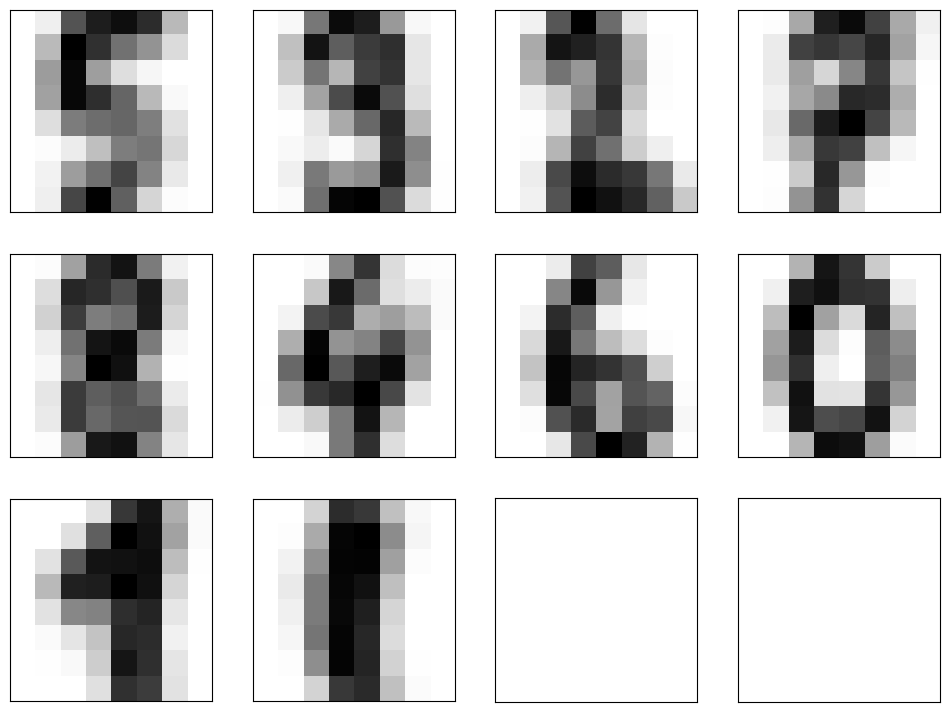

In [7]:
cluster_centers = np.array([x[y_ac_predict == i].mean(axis=0) for i in range(10)]).reshape(-1,8,8)
fig, axis = plt.subplots(nrows=3, ncols=4, figsize=(12,9))
for r_axis in axis:
    for ax in r_axis:
        ax.set_xticks([])
        ax.set_yticks([])
k = 0
for i in range(3):
    for j in range(4):
        if k == 10: break
        image = 1 - cluster_centers[k]
        axis[i,j].imshow(image, cmap='gray')
        k+=1

`ИМХО KMeans дает лучший результат, даже не смотря на то, что там получается размытая 8, т.к. если смотреть на результат агломеративной кластеризации, то 9 вообще не изображена(представлена просто палкой).` 

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M|} \sum_{x' \in M} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.


Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

Text(0, 0.5, 'AC score')

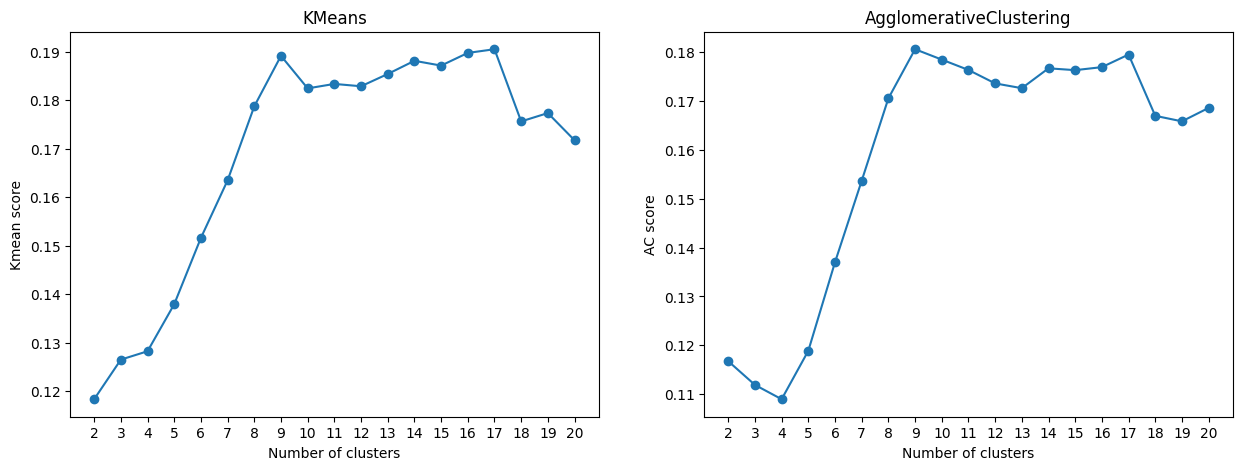

In [8]:
from sklearn.metrics import silhouette_score
kmeans_scores = []
ac_scores = []
for k in range(2,21):
    kmeans = KMeans(k, n_init=100, random_state=23)
    kmeans.fit_predict(x)

    ac = AgglomerativeClustering(k)
    ac.fit_predict(x)

    ac_scores.append(silhouette_score(x, ac.labels_, random_state=23))
    kmeans_scores.append(silhouette_score(x, kmeans.labels_, random_state=23))

fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
for ax in axis:
    ax.set_xticks(range(2,21))

axis[0].plot(range(2,21),kmeans_scores,marker='o')
axis[0].set_title('KMeans')
axis[0].set_xlabel('Number of clusters')
axis[0].set_ylabel('Kmean score')


axis[1].plot(range(2,21), ac_scores, marker='o')
axis[1].set_title('AgglomerativeClustering')
axis[1].set_xlabel('Number of clusters')
axis[1].set_ylabel('AC score')

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

Text(0.5, 1.0, 'V-measure AgglomerativeClustering')

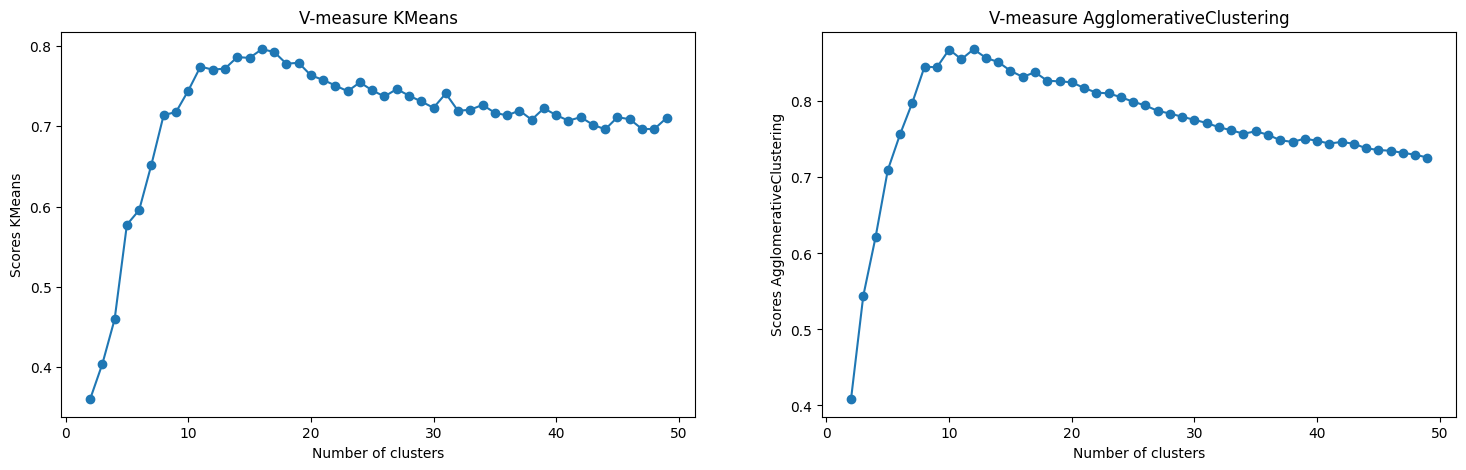

In [9]:
from sklearn.metrics import homogeneity_completeness_v_measure

fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(18,5))

kmeans_scores = []
ac_scores = []

range_ = range(2,50) # я взял 2-50 потому что при 2-21 плохо видно V меру у k-means

for k in range_:
    kmeans = KMeans(n_clusters=k,n_init=100, random_state=23)
    kmeans.fit_predict(x)

    ac = AgglomerativeClustering(n_clusters=k)
    ac.fit_predict(x)

    kmeans_scores.append(homogeneity_completeness_v_measure(y, kmeans.labels_)[2])
    ac_scores.append(homogeneity_completeness_v_measure(y, ac.labels_)[2])


axis[0].plot(range_, kmeans_scores, marker='o')
axis[0].set_ylabel('Scores KMeans')
axis[0].set_xlabel('Number of clusters')
axis[0].set_title('V-measure KMeans')

axis[1].plot(range_, ac_scores, marker='o')
axis[1].set_ylabel('Scores AgglomerativeClustering')
axis[1].set_xlabel('Number of clusters')
axis[1].set_title('V-measure AgglomerativeClustering')

In [10]:
print(f'Max v-measure KMeans: {max(kmeans_scores)} number of clusters: {kmeans_scores.index(max(kmeans_scores))}')
print(f'Max v-measure AgglomerativeClustering: {max(ac_scores)} number of clusters: {ac_scores.index(max(ac_scores))}') 

Max v-measure KMeans: 0.7959130782209456 number of clusters: 14
Max v-measure AgglomerativeClustering: 0.86854875186737 number of clusters: 10


# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

*<u>Замечание:</u>* Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

Text(0.5, 1.0, 'V-measure AgglomerativeClustering')

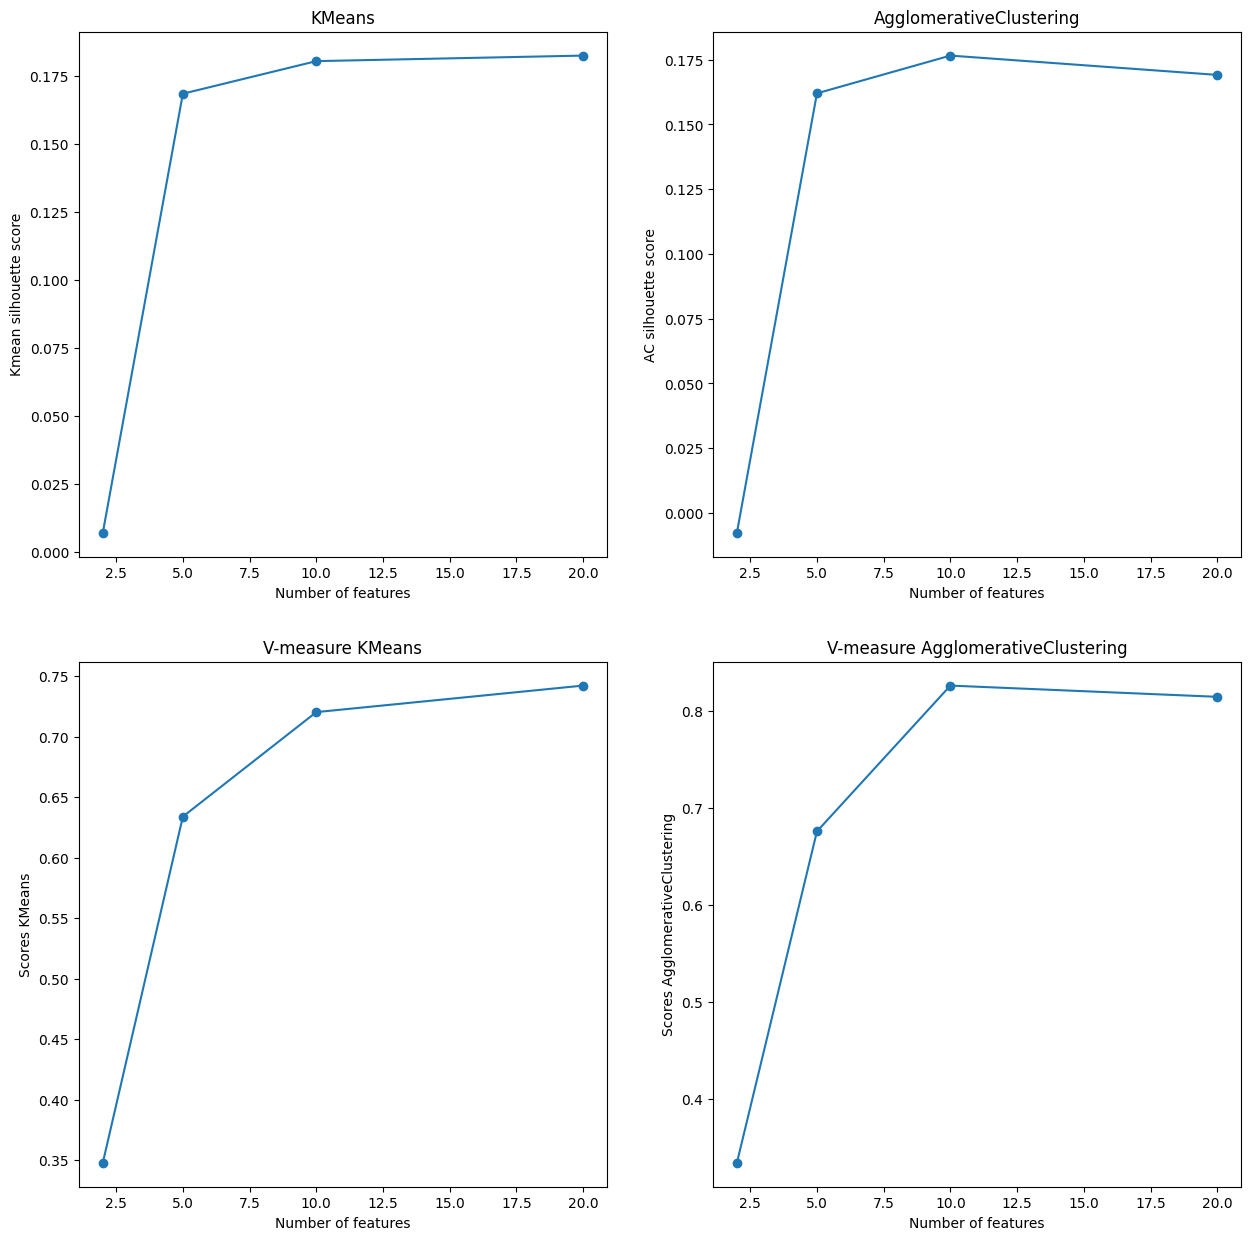

In [11]:
from sklearn.decomposition import TruncatedSVD

kmeans_silhouette_score = []
kmeans_v_score = []
ac_silhouette_score = []
ac_v_score = []

for k in (2,5,10,20):
    svd = TruncatedSVD(k,random_state=23)
    x_reduced = svd.fit_transform(x)

    kmeans = KMeans(n_clusters=10, n_init=100, random_state=23)
    kmeans.fit_predict(x_reduced)

    ac = AgglomerativeClustering(n_clusters=10)
    ac.fit_predict(x_reduced)

    kmeans_silhouette_score.append(silhouette_score(x,kmeans.labels_,random_state=23))
    kmeans_v_score.append(homogeneity_completeness_v_measure(y,kmeans.labels_)[2])

    ac_silhouette_score.append(silhouette_score(x,ac.labels_,random_state=23))
    ac_v_score.append(homogeneity_completeness_v_measure(y,ac.labels_)[2])

fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

axis[0][0].plot((2,5,10,20),kmeans_silhouette_score,marker='o')
axis[0][0].set_title('KMeans')
axis[0][0].set_xlabel('Number of features')
axis[0][0].set_ylabel('Kmean silhouette score')


axis[0][1].plot((2,5,10,20),ac_silhouette_score, marker='o')
axis[0][1].set_title('AgglomerativeClustering')
axis[0][1].set_xlabel('Number of features')
axis[0][1].set_ylabel('AC silhouette score')

axis[1][0].plot((2,5,10,20), kmeans_v_score, marker='o')
axis[1][0].set_ylabel('Scores KMeans')
axis[1][0].set_xlabel('Number of features')
axis[1][0].set_title('V-measure KMeans')

axis[1][1].plot((2,5,10,20), ac_v_score, marker='o')
axis[1][1].set_ylabel('Scores AgglomerativeClustering')
axis[1][1].set_xlabel('Number of features')
axis[1][1].set_title('V-measure AgglomerativeClustering')





In [12]:
for i,k in zip(range(4),(2,5,10,20)):
    print(f'KMeans silhouette score: {kmeans_silhouette_score[i]} v-measure: {kmeans_v_score[i]} features: {k}')

for i,k in zip(range(4),(2,5,10,20)):
    print(f'AgglomerativeClustering silhouette score: {ac_silhouette_score[i]} v-measure: {ac_v_score[i]} features: {k}')


KMeans silhouette score: 0.0071384897534423316 v-measure: 0.3478925250122016 features: 2
KMeans silhouette score: 0.1684930474709176 v-measure: 0.6339843180848354 features: 5
KMeans silhouette score: 0.18046580573988827 v-measure: 0.7203550603165754 features: 10
KMeans silhouette score: 0.18250464186673723 v-measure: 0.7422729794392339 features: 20
AgglomerativeClustering silhouette score: -0.007681018630218928 v-measure: 0.33371899039489245 features: 2
AgglomerativeClustering silhouette score: 0.1620113963829507 v-measure: 0.6756036446423491 features: 5
AgglomerativeClustering silhouette score: 0.1765881132796084 v-measure: 0.8259753348813226 features: 10
AgglomerativeClustering silhouette score: 0.16913283397404957 v-measure: 0.8143882689038883 features: 20


`Получить результат V меры или силуэта выше, чем на исходных данных не удалось`

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.


Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

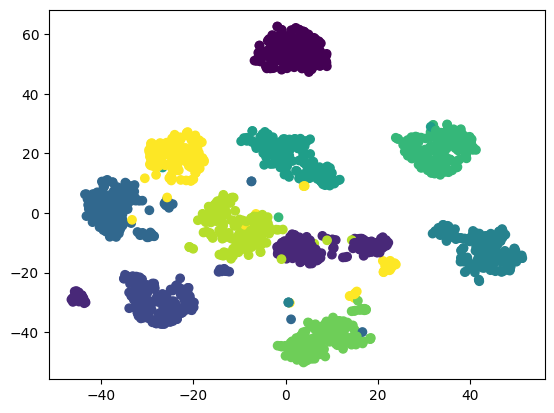

In [13]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=23)
x_reduced = tsne.fit_transform(x,y)
plt.scatter(x_reduced[:,0],x_reduced[:,1],c=y)

Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [59]:
kmeans = KMeans(n_clusters=10, n_init=100)
kmeans_cluster_centers = kmeans.fit_predict(x_reduced)

ac = AgglomerativeClustering(n_clusters=10)
ac_cluster_centers = ac.fit_predict(x_reduced)

kmeans_silhouette_score = silhouette_score(x_reduced, kmeans.labels_, random_state=23)
kmeans_v_measure = homogeneity_completeness_v_measure(y,kmeans.labels_)[2]

ac_silhouette_score = silhouette_score(x_reduced, ac.labels_, random_state=23)
ac_v_measure = homogeneity_completeness_v_measure(y, ac.labels_)[2]

In [20]:
print(f'V-measure KMeans: {kmeans_v_measure} silhouette_score: {kmeans_silhouette_score}')
print(f'V-measure AgglomerativeClustering: {ac_v_measure} silhouette_score: {ac_silhouette_score}') 

V-measure KMeans: 0.9118849641926076 silhouette_score: 0.6405267715454102
V-measure AgglomerativeClustering: 0.911056555346593 silhouette_score: 0.6368752717971802


`Что V мера, что сулуэт получились выше, чем на исходных данных`

Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

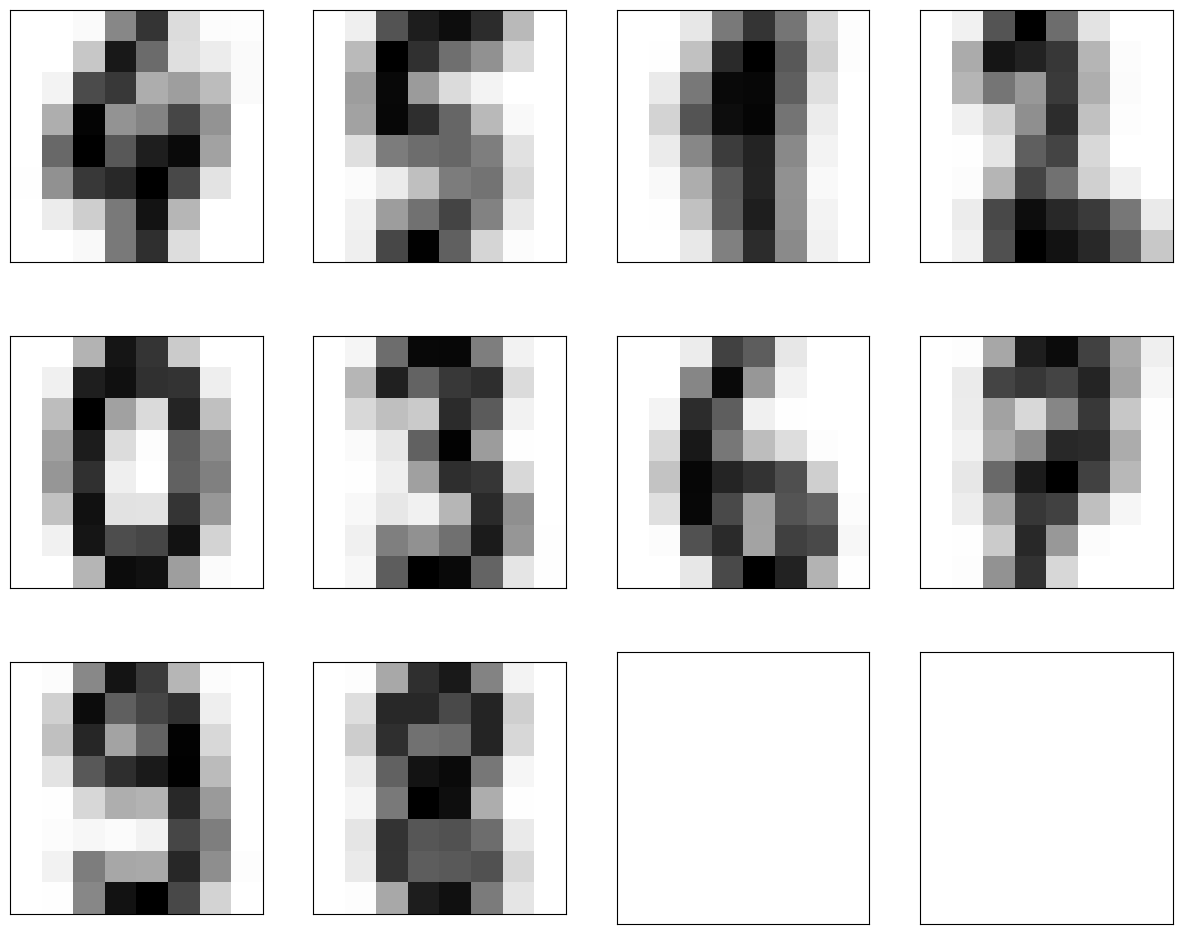

In [60]:
cluster_centers = np.array([x[kmeans_cluster_centers == i].mean(axis=0) for i in range(10)]).reshape(-1,8,8)
fig, axis = plt.subplots(nrows=3,ncols=4, figsize=(15,12))
for r_axis in axis:
    for ax in r_axis:
        ax.set_yticks([])
        ax.set_xticks([])
k = 0
for i in range(3):
    for j in range(4):
        if k == 10: break
        image = 1-cluster_centers[k]
        axis[i][j].imshow(image, cmap='gray')
        k+=1

Да, удалось

# 4. Итоги

Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

`Ответы`
1. К средних дает более осмысленные кластеры, чем алгомеративная кластеризация. У k средних сильно зависит от n_init, т.к. результат кластеризации зависит от того, где алгоритм выберет центры кластеров. Поэтому чем больше значение n_init, тем точнее получится модель, но тогда это становится затратным по времени. У агломеративной кластеризации кроме количества кластеров никаких параметров я не использовал, поэтому не знаю. V мера, как и значение силуэта у АК была выше, чем у к-средних, но при этом центры кластеров были более осмысленны у К средних, поэтому я думаю что зависит, т.к. по посчитанным критериям результат должен быть лучше у АК.
 
2. Улучшить качество кластеризации удалось лишь при снижении размерности с использованием TSNE. V мера при этом была 0.911 у обоих алгоритмов, а значение силуэта 0.64

Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](http://scikit-learn.org/stable/datasets/index.html#downloading-datasets-from-the-mldata-org-repository). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

In [33]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

c:\Users\HAWK\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [73]:
y = mnist.target
x = mnist.data

In [94]:
y = np.array(y,dtype=np.uint8)
x = np.array(x).reshape(-1,28,28)

In [95]:
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

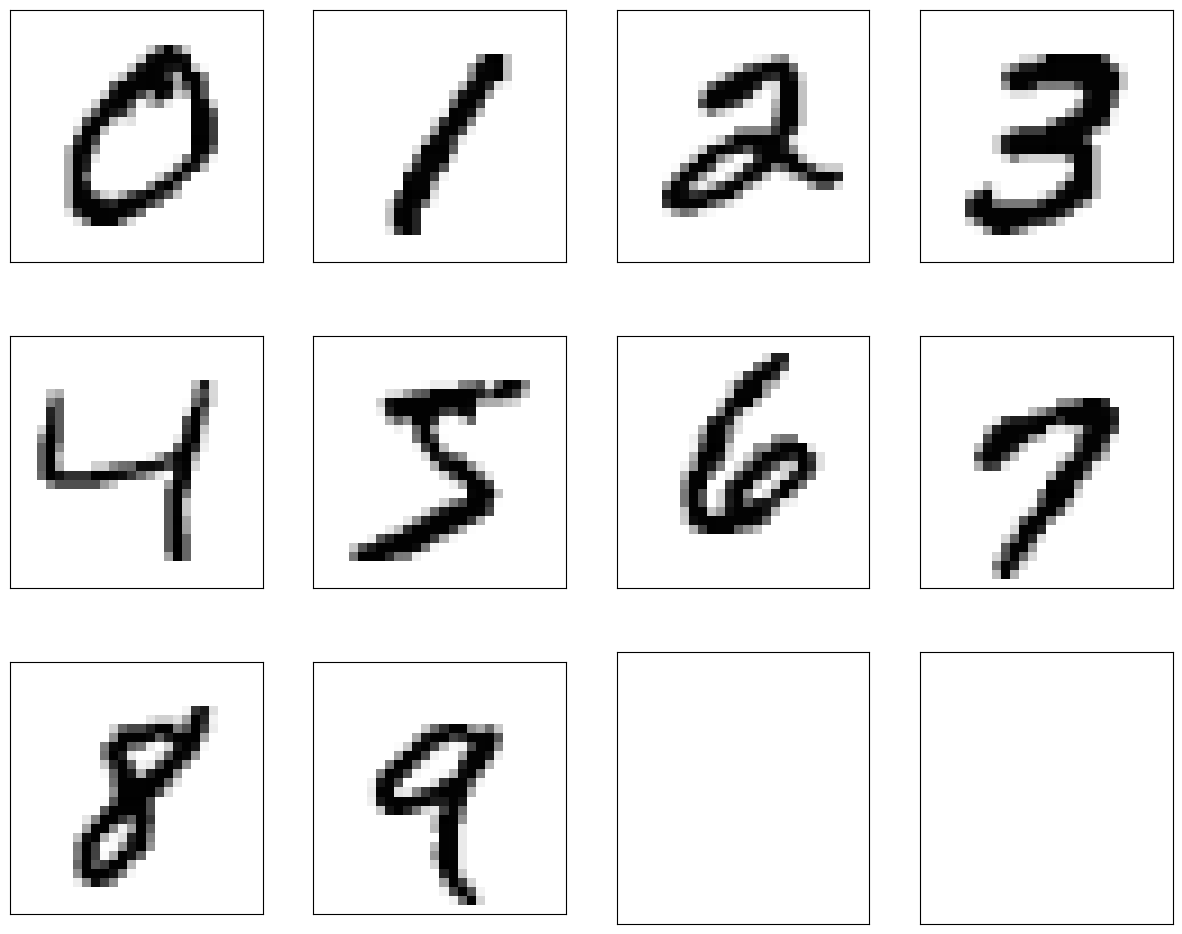

In [99]:
fig, axis = plt.subplots(nrows=3, ncols=4, figsize=(15,12))
for r_axis in axis:
    for ax in r_axis:
        ax.set_xticks([])
        ax.set_yticks([])
k = 0
for i in range(3):
    for j in range(4):
        if k == 10: break
        index = np.argmax(y==k)
        image = 1 - x[index]
        axis[i][j].imshow(image, cmap='gray')
        k+=1

In [102]:
x = x.reshape(-1,784)
kmeans = KMeans(n_clusters=10, n_init=100, random_state=23)
y_pred = kmeans.fit_predict(x)

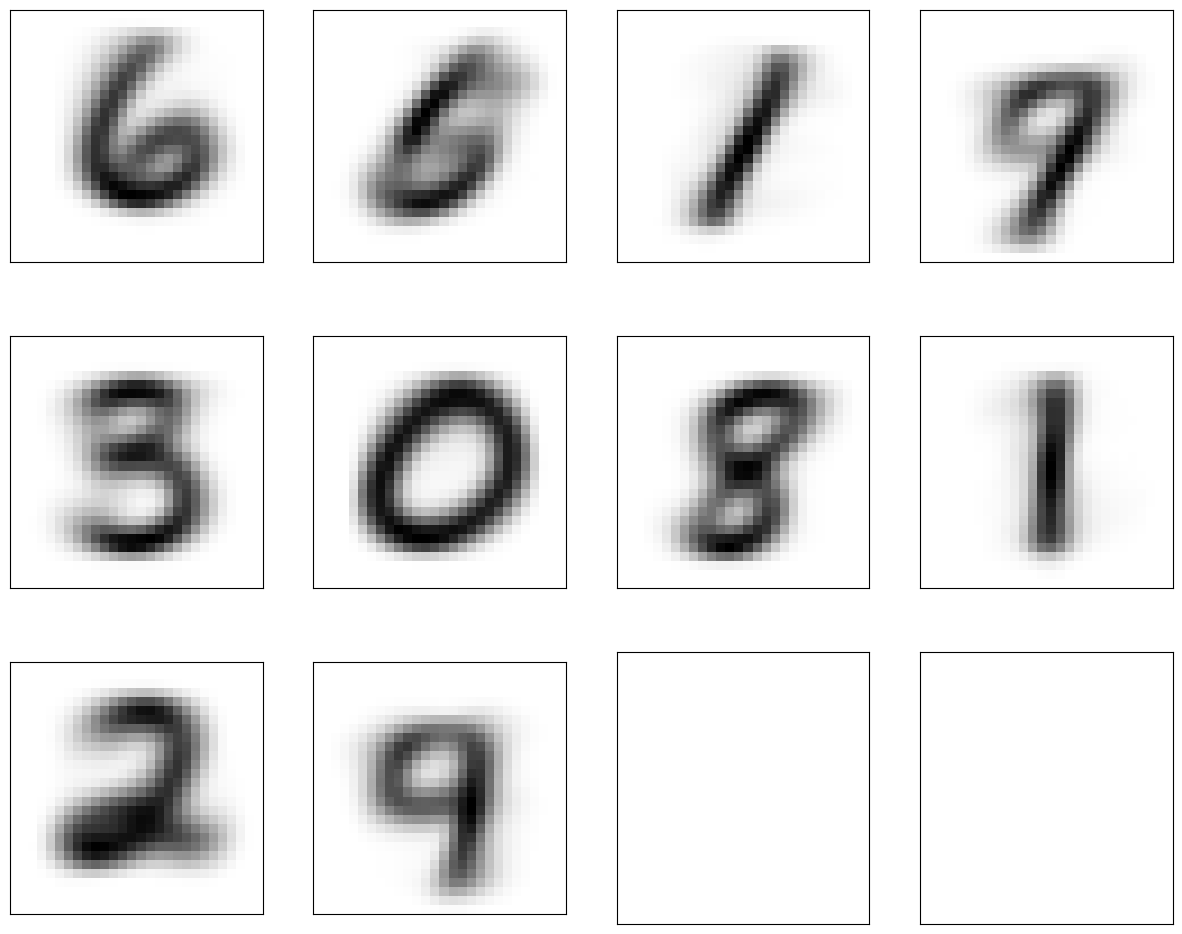

In [105]:
fig, axis = plt.subplots(nrows=3, ncols=4, figsize=(15,12))
for r_axis in axis:
    for ax in r_axis:
        ax.set_xticks([])
        ax.set_yticks([])

cluster_centers = kmeans.cluster_centers_.reshape(-1,28,28)

k = 0
for i in range(3):
    for j in range(4):
        if k == 10: break
        image = 1 - cluster_centers[k]
        axis[i][j].imshow(image, cmap='gray')
        k+=1


In [107]:
kmeans_silhouette_score = silhouette_score(x,kmeans.labels_,random_state=23)
kmeans_v_score = homogeneity_completeness_v_measure(y,kmeans.labels_)[2]
print(f'KMeans silhouette score: {kmeans_silhouette_score} v-measure: {kmeans_v_score}')

KMeans silhouette score: 0.058751928533968906 v-measure: 0.4996036143465733


In [108]:
tsne = TSNE(n_components=2)
x_reduced = tsne.fit_transform(x)

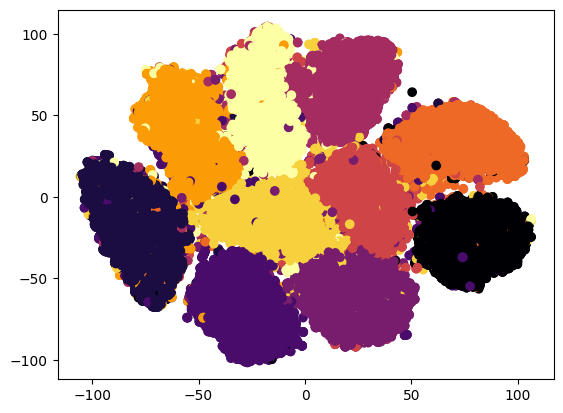

In [110]:
plt.scatter(x_reduced[:,0],x_reduced[:,1],c=y,cmap='inferno')

In [111]:
kmeans_tsne = KMeans(n_clusters=10, n_init=300, random_state=23)
y_pred_tsne = kmeans_tsne.fit_predict(x_reduced)

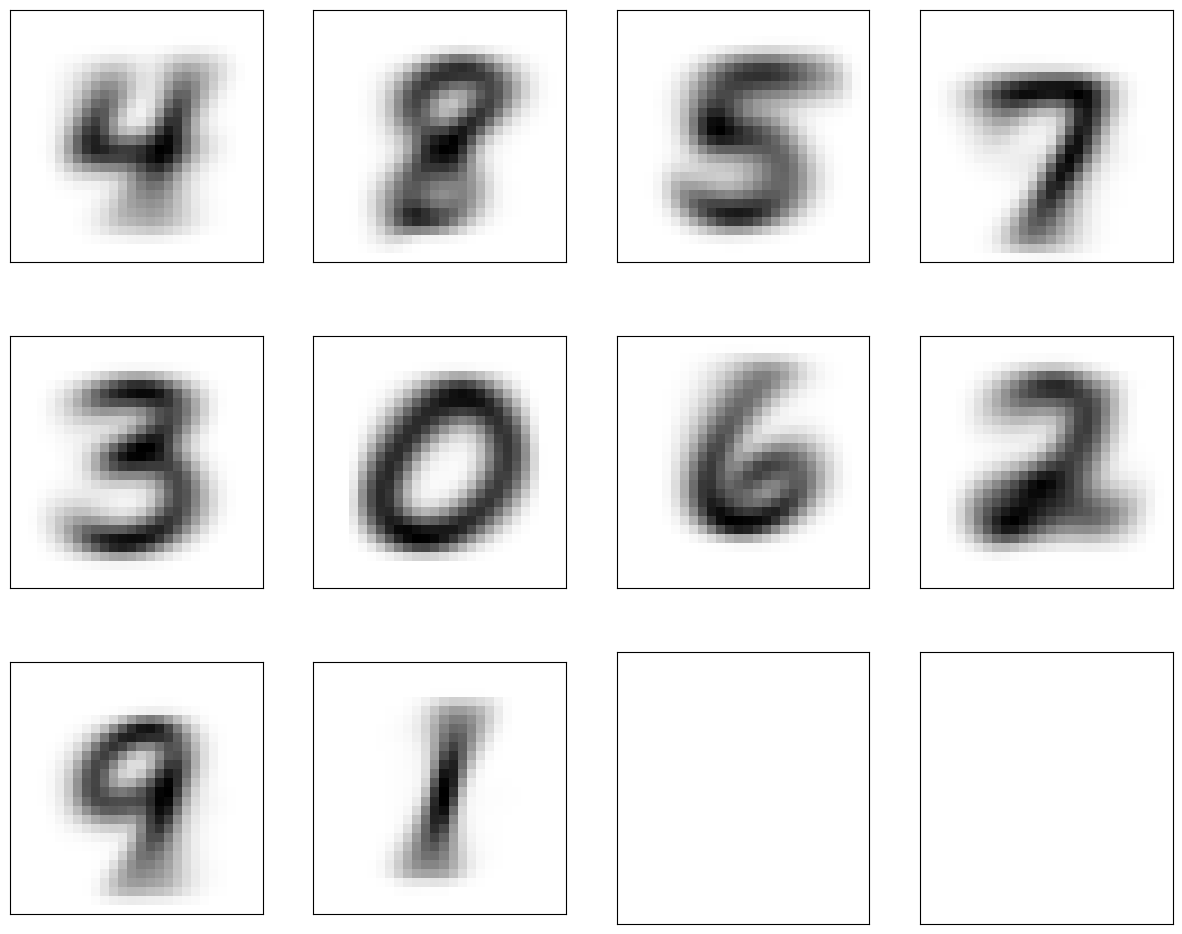

In [113]:
cluster_centers = np.array([x[y_pred_tsne == i].mean(axis=0) for i in range(10)]).reshape(-1,28,28)
fig, axis = plt.subplots(nrows=3, ncols=4, figsize=(15,12))
for r_axis in axis:
    for ax in r_axis:
        ax.set_xticks([])
        ax.set_yticks([])

k = 0
for i in range(3):
    for j in range(4):
        if k == 10: break
        image = 1 - cluster_centers[k]
        axis[i][j].imshow(image, cmap='gray')
        k+=1

In [115]:
kmeans_silhouette_score = silhouette_score(x_reduced,kmeans_tsne.labels_,random_state=23)
kmeans_v_score = homogeneity_completeness_v_measure(y,kmeans_tsne.labels_)[2]
print(f'KMeans silhouette score: {kmeans_silhouette_score} v-measure: {kmeans_v_score}')

KMeans silhouette score: 0.4201524257659912 v-measure: 0.8346994602186687


`Благодаря алгоритму TSNE удалось значительно повысить значение силуэта и V меру(до TSNE силуэт = 0.058751928533968906 V-мера = 0.4996036143465733). Если в первый раз при выводе центров кластеров без снижения размерности 7 и 5 были сильно смазаны, а 4 вообще напоминала 1, то после TSNE каждая цифра отчетливо видна(единственное у 4 размыта ножка).`